In [1]:
#load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generating reproducible results from same code
tf.random.set_seed(14)

In [3]:
# Loading the Data
raw_data = pd.read_csv('forestfires.csv')
raw_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


# EDA

In [4]:
df = raw_data.copy() #Removing the dummies
df.drop(df.columns[11:30], axis = 1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


No Null Values

In [6]:
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


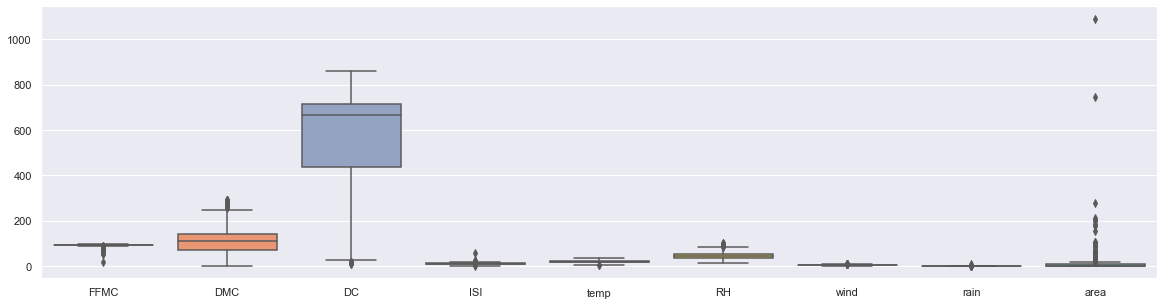

In [7]:
sns.set(rc = {'figure.figsize':(20,5)})
sns.boxplot(data = df, orient = "v", palette = "Set2");

There are outliers in the case of area. But we cannot discard it.

In [8]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [9]:
df.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

The dataset is biased. Lets remove the bias.

In [10]:
# We are going to perform label encoding since it is faster than dummy variables.

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df.month = label_encoder.fit_transform(df.month)

df.day = label_encoder.fit_transform(df.day)

df.size_category = label_encoder.fit_transform(df.size_category)

df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


* Removing Bias in the Dataset

In [11]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:, :-1]
b = resamp.iloc[:, -1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) 

Counter({1: 378, 0: 139})
Counter({1: 374, 0: 374})


Removed bias in dataset.

In [12]:
X = a
y = b
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

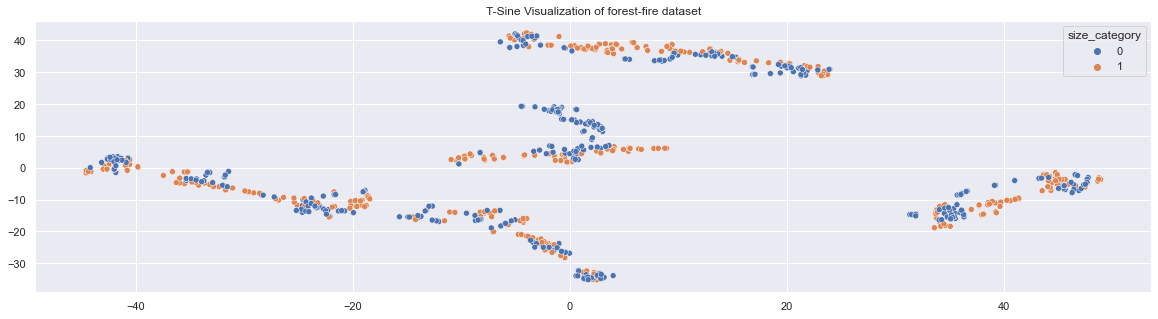

In [13]:
#Visualising the data via dimensionality reduction t-Sine Technique
from sklearn.manifold import TSNE

data_tsne_pca = TSNE(n_components = 2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:, 0], data_tsne_pca[:, 1], hue = b, 
                palette = "deep").set_title('T-Sine Visualization of forest-fire dataset');

# Neural Network Model

* Building the Model

In [14]:
import keras 
from keras.models import Sequential
from keras.layers import Dense

In [15]:
import keras
keras. __version__

'2.5.0'

init method is not available in this version.

In [16]:
# create model
model1 = Sequential()
model1.add(Dense(14, input_dim = 11, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(12,kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [17]:
# Compile model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
# Fit the model
hist1 = model1.fit(X_train, y_train, validation_split = 0.33, epochs = 30, batch_size = 10)

Epoch 1/30
35/35 [==============================] - 17s 22ms/step - loss: 0.6920 - accuracy: 0.4889 - val_loss: 0.6893 - val_accuracy: 0.5145
Epoch 2/30
35/35 [==============================] - 0s 2ms/step - loss: 0.6825 - accuracy: 0.5820 - val_loss: 0.6766 - val_accuracy: 0.5780
Epoch 3/30
35/35 [==============================] - 0s 2ms/step - loss: 0.6687 - accuracy: 0.6765 - val_loss: 0.6438 - val_accuracy: 0.6994
Epoch 4/30
35/35 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.7462 - val_loss: 0.6022 - val_accuracy: 0.6243
Epoch 5/30
35/35 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7028 - val_loss: 0.5131 - val_accuracy: 0.6936
Epoch 6/30
35/35 [==============================] - 0s 3ms/step - loss: 0.4879 - accuracy: 0.7575 - val_loss: 0.4324 - val_accuracy: 0.9249
Epoch 7/30
35/35 [==============================] - 0s 2ms/step - loss: 0.3960 - accuracy: 0.8483 - val_loss: 0.3562 - val_accuracy: 0.8382
Epoch 8/30
35/35 [

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                168       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


* Model Evaluation

In [20]:
test_loss, test_acc = model1.evaluate(X_test, y_test)

8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9867


In [21]:
hist1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"] = hist1.epoch

hist1_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
25,0.054427,0.988571,0.033130,1.000000,25
26,0.059199,0.980000,0.095346,0.959538,26
27,0.042397,0.985714,0.027396,1.000000,27
28,0.034039,0.991429,0.028215,1.000000,28
29,0.074451,0.971429,0.022699,1.000000,29


* Visualize Training History

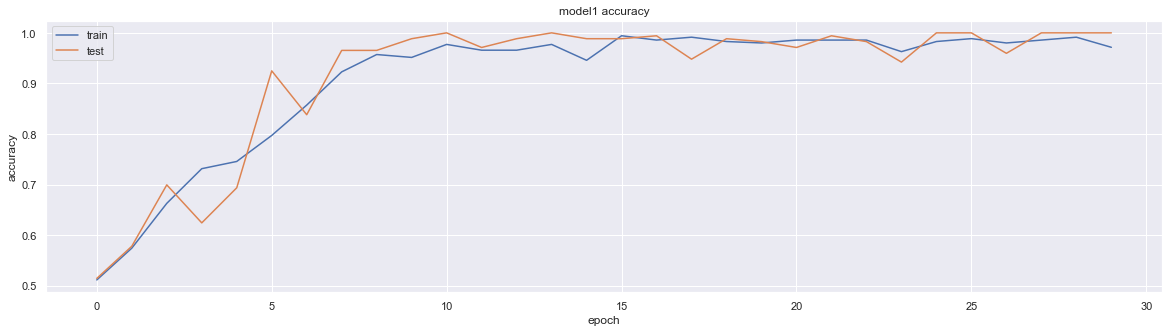

In [23]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

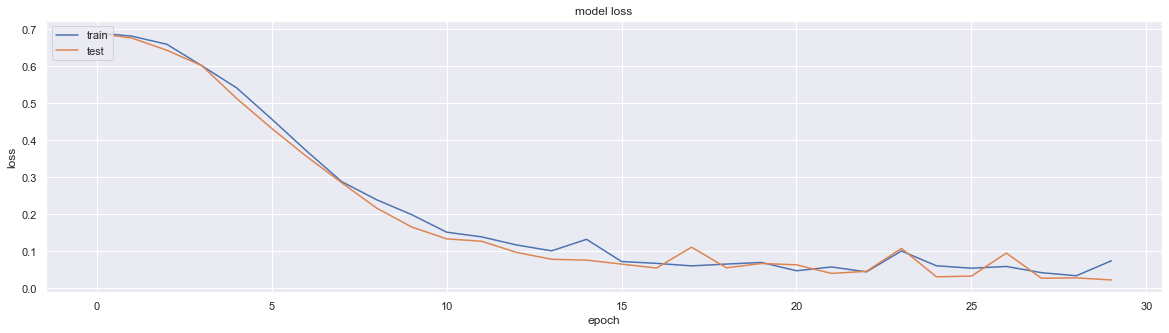

In [24]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

Loss decreases and starts oscillating after 25.

# Tuning HyperParameters

* Standardizing X values

In [25]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

In [26]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

* Tuning set 1 : Batch Size and Epochs

In [27]:
# create model function
def create_model():
    model = Sequential()
    model.add(Dense(14, input_dim = 11, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(12, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    adam = Adam(lr = 0.01) #learning rate = 0.01
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [28]:
# Create the model
model = KerasClassifier(build_fn = create_model, verbose = 0)

# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,25,50,100]

# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size, epochs = epochs)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10)
grid_result = grid.fit(X_standardized, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] batch_size=10, epochs=10 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ batch_size=10, epochs=10, score=0.980, total=   2.0s
[CV] batch_size=10, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ............ batch_size=10, epochs=10, score=0.967, total=   2.0s
[CV] batch_size=10, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ............ batch_size=10, epochs=10, score=0.933, total=   1.9s
[CV] batch_size=10, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] ............ batch_size=10, epochs=10, score=0.966, total=   1.8s
[CV] batch_size=10, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV] ............ batch_size=10, epochs=10, score=0.973, total=   1.9s
[CV] batch_size=10, epochs=25 ........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s


[CV] ............ batch_size=10, epochs=25, score=0.993, total=   2.9s
[CV] batch_size=10, epochs=25 ........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.4s remaining:    0.0s


[CV] ............ batch_size=10, epochs=25, score=0.967, total=   2.9s
[CV] batch_size=10, epochs=25 ........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   15.3s remaining:    0.0s


[CV] ............ batch_size=10, epochs=25, score=0.947, total=   3.1s
[CV] batch_size=10, epochs=25 ........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.3s remaining:    0.0s


[CV] ............ batch_size=10, epochs=25, score=0.966, total=   2.9s
[CV] batch_size=10, epochs=25 ........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.2s remaining:    0.0s


[CV] ............ batch_size=10, epochs=25, score=0.980, total=   2.6s
[CV] batch_size=10, epochs=50 ........................................
[CV] ............ batch_size=10, epochs=50, score=1.000, total=   3.8s
[CV] batch_size=10, epochs=50 ........................................
[CV] ............ batch_size=10, epochs=50, score=0.960, total=   4.3s
[CV] batch_size=10, epochs=50 ........................................
[CV] ............ batch_size=10, epochs=50, score=0.953, total=   4.3s
[CV] batch_size=10, epochs=50 ........................................
[CV] ............ batch_size=10, epochs=50, score=0.987, total=   4.5s
[CV] batch_size=10, epochs=50 ........................................
[CV] ............ batch_size=10, epochs=50, score=0.993, total=   4.6s
[CV] batch_size=10, epochs=100 .......................................
[CV] ........... batch_size=10, epochs=100, score=0.993, total=   7.6s
[CV] batch_size=10, epochs=100 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.1min finished


In [29]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9839910507202149, using {'batch_size': 20, 'epochs': 25}
0.963919460773468,0.01608287117905518 with: {'batch_size': 10, 'epochs': 10}
0.9705950736999511,0.015544882016374774 with: {'batch_size': 10, 'epochs': 25}
0.9786398053169251,0.018556440064246886 with: {'batch_size': 10, 'epochs': 50}
0.9786308765411377,0.016557923653204076 with: {'batch_size': 10, 'epochs': 100}
0.9518120765686036,0.01973079985000717 with: {'batch_size': 20, 'epochs': 10}
0.9839910507202149,0.019132580035605442 with: {'batch_size': 20, 'epochs': 25}
0.9772796273231507,0.013089789317026469 with: {'batch_size': 20, 'epochs': 50}
0.9799821019172669,0.0183657544421694 with: {'batch_size': 20, 'epochs': 100}
0.9465861201286316,0.02950077343936037 with: {'batch_size': 40, 'epochs': 10}
0.9745950818061828,0.026204887477535944 with: {'batch_size': 40, 'epochs': 25}
0.9786219120025634,0.015438476077378045 with: {'batch_size': 40, 'epochs': 50}
0.9813064813613892,0.014833749414385514 with: {'batch_size': 40, 'epo

According to this, the best batch size is 20 and epochs is 50.

* Tuning set 2 : Learning Rate and Dropout Rate

In [30]:
from keras.layers import Dropout

# Defining the model

def create_model2(learning_rate, dropout_rate):
    model = Sequential()
    model.add(Dense(14, input_dim = 11, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12, input_dim = 14, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# Create the model

model2 = KerasClassifier(build_fn = create_model2, verbose = 0, batch_size = 20, epochs = 50)

# Define the grid search parameters

learning_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2]

# Make a dictionary of the grid search parameters

param_grids2 = dict(learning_rate = learning_rate, dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid2 = GridSearchCV(estimator = model2, param_grid = param_grids2, cv = KFold(), verbose = 10)
grid_result2 = grid2.fit(X_standardized, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  dropout_rate=0.0, learning_rate=0.001, score=0.993, total=   3.9s
[CV] dropout_rate=0.0, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.001, score=0.993, total=   3.2s
[CV] dropout_rate=0.0, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.001, score=0.967, total=   3.3s
[CV] dropout_rate=0.0, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.001, score=0.973, total=   3.1s
[CV] dropout_rate=0.0, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.3s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.001, score=0.993, total=   2.8s
[CV] dropout_rate=0.0, learning_rate=0.01 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.1s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.01, score=0.987, total=   2.8s
[CV] dropout_rate=0.0, learning_rate=0.01 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.9s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.01, score=0.993, total=   2.8s
[CV] dropout_rate=0.0, learning_rate=0.01 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.7s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.01, score=0.953, total=   2.9s
[CV] dropout_rate=0.0, learning_rate=0.01 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.6s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.01, score=0.987, total=   3.5s
[CV] dropout_rate=0.0, learning_rate=0.01 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.1s remaining:    0.0s


[CV]  dropout_rate=0.0, learning_rate=0.01, score=1.000, total=   3.5s
[CV] dropout_rate=0.0, learning_rate=0.1 .............................
[CV] . dropout_rate=0.0, learning_rate=0.1, score=0.000, total=   3.4s
[CV] dropout_rate=0.0, learning_rate=0.1 .............................
[CV] . dropout_rate=0.0, learning_rate=0.1, score=0.920, total=   3.3s
[CV] dropout_rate=0.0, learning_rate=0.1 .............................
[CV] . dropout_rate=0.0, learning_rate=0.1, score=0.947, total=   3.8s
[CV] dropout_rate=0.0, learning_rate=0.1 .............................
[CV] . dropout_rate=0.0, learning_rate=0.1, score=0.980, total=   3.4s
[CV] dropout_rate=0.0, learning_rate=0.1 .............................
[CV] . dropout_rate=0.0, learning_rate=0.1, score=0.960, total=   3.4s
[CV] dropout_rate=0.1, learning_rate=0.001 ...........................
[CV]  dropout_rate=0.1, learning_rate=0.001, score=1.000, total=   3.7s
[CV] dropout_rate=0.1, learning_rate=0.001 ...........................
[CV] 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.4min finished


In [31]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_, grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9906577110290528, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9839552521705628,0.011649577574067226 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9839820981025695,0.016107811120968662 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.7612527966499328,0.3811220917630825 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9879820942878723,0.011461470443828007 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.973315441608429,0.03398644951216185 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9332259654998779,0.049315314566039437 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9906577110290528,0.012362918046183854 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9866487622261048,0.011155535212879646 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.810872483253479,0.2764757829973954 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


Best score for Dropout rate = 0.2 and learning rate is 0.001.

* Tuning set 3 : Activation Function and Kernel Initializer

In [32]:
# Defining the model

def create_model3(activation_function, init):
    model = Sequential()
    model.add(Dense(14, input_dim = 11, kernel_initializer = init, activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12, input_dim = 14, kernel_initializer = init, activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# Create the model

model3 = KerasClassifier(build_fn = create_model3, verbose = 0, batch_size = 20, epochs = 50)

# Define the grid search parameters
activation_function = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function, init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3, param_grid = param_grids3, cv = KFold(), verbose = 10)
grid_result3 = grid3.fit(X_standardized, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] activation_function=softmax, init=uniform .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation_function=softmax, init=uniform, score=0.040, total=   3.1s
[CV] activation_function=softmax, init=uniform .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  activation_function=softmax, init=uniform, score=0.787, total=   3.2s
[CV] activation_function=softmax, init=uniform .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  activation_function=softmax, init=uniform, score=0.480, total=   2.9s
[CV] activation_function=softmax, init=uniform .......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV]  activation_function=softmax, init=uniform, score=0.591, total=   2.9s
[CV] activation_function=softmax, init=uniform .......................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV]  activation_function=softmax, init=uniform, score=0.020, total=   2.9s
[CV] activation_function=softmax, init=normal ........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s


[CV]  activation_function=softmax, init=normal, score=0.013, total=   2.9s
[CV] activation_function=softmax, init=normal ........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.9s remaining:    0.0s


[CV]  activation_function=softmax, init=normal, score=0.793, total=   2.9s
[CV] activation_function=softmax, init=normal ........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.8s remaining:    0.0s


[CV]  activation_function=softmax, init=normal, score=0.493, total=   2.9s
[CV] activation_function=softmax, init=normal ........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.8s remaining:    0.0s


[CV]  activation_function=softmax, init=normal, score=0.624, total=   3.0s
[CV] activation_function=softmax, init=normal ........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.8s remaining:    0.0s


[CV]  activation_function=softmax, init=normal, score=0.054, total=   3.0s
[CV] activation_function=softmax, init=zero ..........................
[CV]  activation_function=softmax, init=zero, score=0.047, total=   3.7s
[CV] activation_function=softmax, init=zero ..........................
[CV]  activation_function=softmax, init=zero, score=0.767, total=   3.0s
[CV] activation_function=softmax, init=zero ..........................
[CV]  activation_function=softmax, init=zero, score=0.427, total=   3.0s
[CV] activation_function=softmax, init=zero ..........................
[CV]  activation_function=softmax, init=zero, score=0.557, total=   3.0s
[CV] activation_function=softmax, init=zero ..........................
[CV]  activation_function=softmax, init=zero, score=0.000, total=   3.0s
[CV] activation_function=relu, init=uniform ..........................
[CV]  activation_function=relu, init=uniform, score=1.000, total=   2.9s
[CV] activation_function=relu, init=uniform .................

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.0min finished


In [33]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9946666717529297, using {'activation_function': 'linear', 'init': 'normal'}
0.38348098285496235,0.30488510369040883 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.3955704730004072,0.31080963972116576 with: {'activation_function': 'softmax', 'init': 'normal'}
0.35940940082073214,0.2954406093375782 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9906487584114074,0.012360993303669573 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9893243789672852,0.014964256467540295 with: {'activation_function': 'relu', 'init': 'normal'}
0.20568233132362365,0.18712200548292038 with: {'activation_function': 'relu', 'init': 'zero'}
0.9933333277702332,0.013333344459533693 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9919910550117492,0.009796747616825852 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20568233132362365,0.18712200548292038 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9919910430908203,0.01292624628906464 with: {'

Best activation function in our case would be Relu and Kernel Initializer is Uniform.

* Tuning Set 4: Number of neurons in activation layer

In [34]:
# Defining the model

def create_model4(neuron1, neuron2):
    model = Sequential()
    model.add(Dense(neuron1, input_dim = 11, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer = 'uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# Create the model

model4 = KerasClassifier(build_fn = create_model4, verbose = 0, batch_size = 20, epochs = 50)

# Define the grid search parameters

neuron1 = [4, 8, 14]
neuron2 = [4, 8, 12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1, neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4, param_grid = param_grids4, cv = KFold(), verbose = 10)
grid_result4 = grid4.fit(X_standardized, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ neuron1=4, neuron2=4, score=1.000, total=   2.9s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.993, total=   2.9s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.960, total=   3.0s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.987, total=   2.8s
[CV] neuron1=4, neuron2=4 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.6s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=4, score=0.879, total=   2.9s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=1.000, total=   3.3s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.8s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.973, total=   2.9s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.7s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.967, total=   2.7s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.5s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=1.000, total=   2.8s
[CV] neuron1=4, neuron2=8 ............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.3s remaining:    0.0s


[CV] ................ neuron1=4, neuron2=8, score=0.966, total=   2.8s
[CV] neuron1=4, neuron2=12 ...........................................
[CV] ............... neuron1=4, neuron2=12, score=1.000, total=   2.8s
[CV] neuron1=4, neuron2=12 ...........................................
[CV] ............... neuron1=4, neuron2=12, score=1.000, total=   2.8s
[CV] neuron1=4, neuron2=12 ...........................................
[CV] ............... neuron1=4, neuron2=12, score=0.960, total=   2.8s
[CV] neuron1=4, neuron2=12 ...........................................
[CV] ............... neuron1=4, neuron2=12, score=0.993, total=   2.8s
[CV] neuron1=4, neuron2=12 ...........................................
[CV] ............... neuron1=4, neuron2=12, score=0.993, total=   3.1s
[CV] neuron1=8, neuron2=4 ............................................
[CV] ................ neuron1=8, neuron2=4, score=1.000, total=   2.8s
[CV] neuron1=8, neuron2=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.2min finished


In [35]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_, grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9920000076293946, using {'neuron1': 8, 'neuron2': 12}
0.963821017742157,0.04443864444934746 with: {'neuron1': 4, 'neuron2': 4}
0.9812885880470276,0.01547717114936944 with: {'neuron1': 4, 'neuron2': 8}
0.9893154263496399,0.0149618685610702 with: {'neuron1': 4, 'neuron2': 12}
0.9839731574058532,0.017185136857448255 with: {'neuron1': 8, 'neuron2': 4}
0.9893243789672852,0.012361951189163403 with: {'neuron1': 8, 'neuron2': 8}
0.9920000076293946,0.010666656494140624 with: {'neuron1': 8, 'neuron2': 12}
0.9879731416702271,0.011467752515669366 with: {'neuron1': 14, 'neuron2': 4}
0.9839641928672791,0.0090326612244006 with: {'neuron1': 14, 'neuron2': 8}
0.9879910469055175,0.017585175453531412 with: {'neuron1': 14, 'neuron2': 12}


Best results are Neuron 1 = 4 and Neuron 2 = 4.

# Final Model

In [36]:
# Defining the model

def create_model_fnl():
    model = Sequential()
    model.add(Dense(4, input_dim = 11, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [37]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl, verbose = 0, batch_size = 20, epochs = 50)

In [38]:
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized, y, test_size = 0.3)

In [39]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1, y_train_1)

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1, model_preds))
    print(classification_report(y_test_1, model_preds))

In [41]:
report_model(model_fnl)

[[117   2]
 [  0 106]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       119
           1       0.98      1.00      0.99       106

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225

